In [7]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import skforecast
import sklearn
import xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

# Warnings configuration
# ==============================================================================
import warnings

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version xgboost: {xgboost.__version__}")

Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version xgboost: 3.0.0


In [5]:
#pip install lightgbm

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.5 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.9 MB/s eta 0:00:00


In [8]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()
data.head(4)

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
Freq: MS, Name: Passengers, dtype: int64

In [9]:
# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data.to_numpy())
data_diff = pd.Series(data_diff, index=data.index).dropna()
data_diff.head(4)

Date
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Freq: MS, dtype: float64

Train dates : 1949-01-01 00:00:00 --- 1955-12-01 00:00:00  (n=84)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


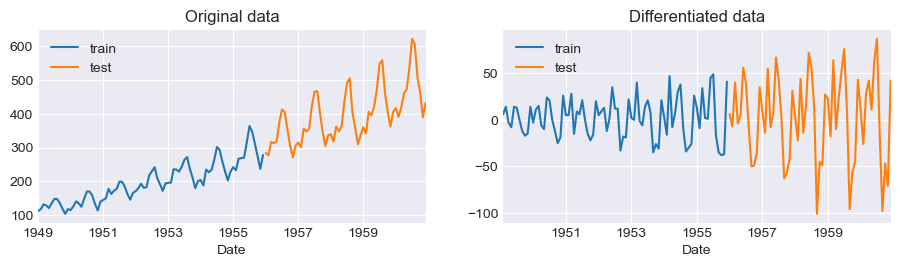

In [10]:
# Data partition train-test
# ==============================================================================
end_train = '1955-12-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

Error (MAE) Random Forest: 66.10
Error (MAE) Gradient Boosting: 55.38


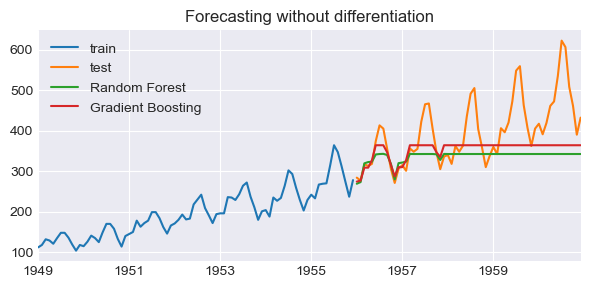

In [11]:
# Forecasting without differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterRecursive(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )
forecaster_gb = ForecasterRecursive(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

Error (MAE) Random Forest: 53.76
Error (MAE) Gradient Boosting: 29.77


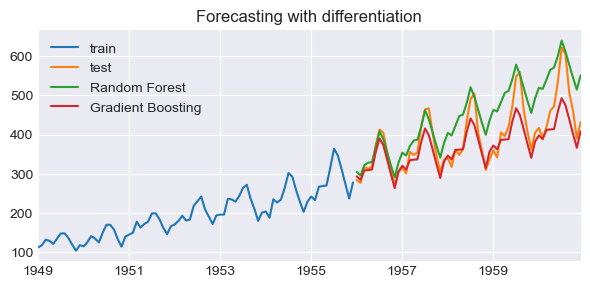

In [12]:
# Forecasting with differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterRecursive(
                    regressor       = RandomForestRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
forecaster_gb = ForecasterRecursive(
                    regressor       = XGBRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting with differentiation')
ax.set_xlabel('')
ax.legend();

In [13]:
# Differentiation with TimeSeriesDifferentiator
# ==============================================================================
y = np.array([5, 8, 12, 10, 14, 17, 21, 19], dtype=float)
diffenciator = TimeSeriesDifferentiator()
diffenciator.fit(y)
y_diff = diffenciator.transform(y)

print(f"Original time series   : {y}")
print(f"Differenced time series: {y_diff}")

Original time series   : [ 5.  8. 12. 10. 14. 17. 21. 19.]
Differenced time series: [nan  3.  4. -2.  4.  3.  4. -2.]


In [14]:
# Inverse transform
# ==============================================================================
diffenciator.inverse_transform(y_diff)

array([ 5.,  8., 12., 10., 14., 17., 21., 19.])

In [15]:
# Time series differentiated by preprocessing before training
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data.to_numpy())
data_diff = pd.Series(data_diff, index=data.index).dropna()

forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
forecaster.fit(y=data_diff.loc[:end_train])
predictions_diff = forecaster.predict(steps=steps)

# Revert differentiation to obtain final predictions
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
predictions_1 = predictions_1.asfreq('MS')
predictions_1.name = 'pred'
predictions_1.head(5)

1956-01-01    303.18
1956-02-01    293.70
1956-03-01    322.68
1956-04-01    326.52
1956-05-01    326.79
Freq: MS, Name: pred, dtype: float64

In [16]:
# Time series differentiated internally by the forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
             )
forecaster.fit(y=data.loc[:end_train])
predictions_2 = forecaster.predict(steps=steps)
predictions_2.head(5)

1956-01-01    303.18
1956-02-01    293.70
1956-03-01    322.68
1956-04-01    326.52
1956-05-01    326.79
Freq: MS, Name: pred, dtype: float64

In [18]:
# Compare both predictions
# ==============================================================================
print(pd.testing.assert_series_equal(predictions_1, predictions_2))

None


In [19]:
# Backtesting with the time series differentiated by preprocessing before training
# ==============================================================================
forecaster_1 = ForecasterRecursive(
                   regressor = RandomForestRegressor(random_state=963),
                   lags      = 15
               )
cv = TimeSeriesFold(
        steps              = 5,
        initial_train_size = len(data_diff.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
     )
_, predictions_1 = backtesting_forecaster(
                        forecaster    = forecaster_1,
                        y             = data_diff,
                        cv            = cv,
                        metric        = 'mean_squared_error',
                    )

# Revert differentiation of predictions. Predictions of each fold must be reverted
# individually. An id is added to each prediction to identify the fold to which it belongs.
predictions_1 = predictions_1.rename(columns={'pred': 'pred_diff'})
folds = len(predictions_1) / cv.steps
folds = int(np.ceil(folds))
predictions_1['backtesting_fold_id'] = np.repeat(range(folds), cv.steps)[:len(predictions_1)]

# Add the previously observed value of the time series (only to the first prediction of each fold)
previous_overved_values = data.shift(1).loc[predictions_1.index].iloc[::cv.steps]
previous_overved_values.name = 'previous_overved_value'
predictions_1 = predictions_1.merge(
                    previous_overved_values,
                    left_index  = True,
                    right_index = True,
                    how         = 'left'
                )
predictions_1 = predictions_1.fillna(0)
predictions_1['summed_value'] = (
    predictions_1['pred_diff'] + predictions_1['previous_overved_value']
)

# Revert differentiation using the cumulative sum by fold
predictions_1['pred'] = (
    predictions_1
    .groupby('backtesting_fold_id')
    .apply(lambda x: x['summed_value'].cumsum(), include_groups=False)
    .to_numpy()
)

predictions_1.head(5)

  0%|          | 0/12 [00:00<?, ?it/s]

,pred_diff,backtesting_fold_id,previous_overved_value,summed_value,pred
1956-01-01,25.18,0,278.0,303.18,303.18
1956-02-01,-9.48,0,0.0,-9.48,293.70
1956-03-01,28.98,0,0.0,28.98,322.68
1956-04-01,3.84,0,0.0,3.84,326.52
1956-05-01,0.27,0,0.0,0.27,326.79


In [20]:
# Backtesting with the time series differentiated internally
# ==============================================================================
forecaster_2 = ForecasterRecursive(
                   regressor       = RandomForestRegressor(random_state=963),
                   lags            = 15,
                   differentiation = 1
               )
cv = TimeSeriesFold(
        steps              = 5,
        initial_train_size = len(data.loc[:end_train]),
        refit              = True,
        fixed_train_size   = False,
        differentiation    = 1
     )

_, predictions_2 = backtesting_forecaster(
                        forecaster    = forecaster_2,
                        y             = data,
                        cv            = cv,
                        metric        = 'mean_squared_error'
                    )

predictions_2.head(5)

  0%|          | 0/12 [00:00<?, ?it/s]

,pred
1956-01-01,303.18
1956-02-01,293.70
1956-03-01,322.68
1956-04-01,326.52
1956-05-01,326.79


In [22]:
# Compare both predictions
# ==============================================================================
print(pd.testing.assert_series_equal(predictions_1['pred'], predictions_2['pred']))

None


Error (MAE) Gradient Boosting with linear trees: 29.77


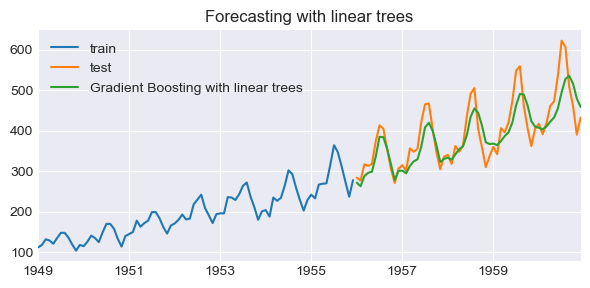

In [23]:
# Forecasting with linear trees
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
regressor = LGBMRegressor(n_estimators=25, linear_tree=True, random_state=963, verbose=-1)
forecaster_lgbm_linear = ForecasterRecursive(
                            regressor = regressor,
                            lags      = 12
                         )
# Train
forecaster_lgbm_linear.fit(data.loc[:end_train])

# Predict
predictions_lgbm_linear = forecaster_lgbm_linear.predict(steps=steps)

# Error
error_lgbm_linear = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Gradient Boosting with linear trees: {error_lgbm_linear:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_lgbm_linear.plot(ax=ax, label='Gradient Boosting with linear trees')
ax.set_title('Forecasting with linear trees')
ax.set_xlabel('')
ax.legend();